In [1]:
%pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# python imports
import os
from tqdm import tqdm

# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# helper functions for computer vision
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets

import argparse

import scipy.io

import matplotlib.pyplot as plt
import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# Import MNIST

from torchvision.datasets import EMNIST
#torchvision.datasets.EMNIST()
# Download and Save MNIST 
digits_train = EMNIST( './emnist_data', train=True, split="mnist", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                  transforms.RandomCrop(size = 32, padding = 2, fill=0), 
                                                                                                                  lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                  lambda img: torchvision.transforms.functional.hflip(img)]))
digits_train_large = EMNIST( './emnist_data', train=True, split="digits", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                         transforms.RandomCrop(size = 32, padding = 2, fill=0),
                                                                                                                         lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                         lambda img: torchvision.transforms.functional.hflip(img)]))
letters_train = EMNIST( './emnist_data', train=True, split="letters", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                     transforms.RandomCrop(size = 32, padding = 2, fill=0),
                                                                                                                     lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                     lambda img: torchvision.transforms.functional.hflip(img)]))
letters_train.targets += 9

digits_test = EMNIST( './emnist_data', train=False, split="mnist", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                  transforms.RandomCrop(size = 32, padding = 2, fill=0), 
                                                                                                                  lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                  lambda img: torchvision.transforms.functional.hflip(img)]))
digits_test_large = EMNIST( './emnist_data', train=False, split="digits", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                         transforms.RandomCrop(size = 32, padding = 2, fill=0),
                                                                                                                         lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                         lambda img: torchvision.transforms.functional.hflip(img)]))
letters_test = EMNIST( './emnist_data', train=False, split="letters", download=True, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                                     transforms.RandomCrop(size = 32, padding = 2, fill=0),
                                                                                                                     lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                                                                     lambda img: torchvision.transforms.functional.hflip(img)]))
letters_test.targets += 9

comb_train = torch.utils.data.ConcatDataset([digits_train,letters_train])
#comb_train = digits_train_large
comb_test = torch.utils.data.ConcatDataset([digits_test,letters_test])
#comb_test = digits_test_large
#data_train = torch.utils.data.DataLoader(comb_train , batch_size=128,shuffle=True )

#data_test = torch.utils.data.DataLoader( comb_test , batch_size=128,shuffle=True )
#for batch_idx, samples in enumerate(data_train):
    #print(batch_idx, samples)

In [4]:
comb_train[5][0][0].shape

torch.Size([32, 32])

In [5]:
# for i in range(len(comb_train)):
#     temp = list(comb_train[i])
#     temp_matrix = temp[0][0].clone().T
#     temp[0][0] = temp_matrix
#     comb_train[i] = tuple(temp)

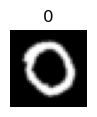

In [6]:
figure = plt.figure(figsize=(1, 1))
cols, rows = 1, 1
sample_idx = 5
img, label = comb_test[sample_idx]
figure.add_subplot(rows, cols, 1)
plt.title(label) 
plt.axis("off")
plt.imshow(img.view(32,32), cmap="gray")
#plt.show()

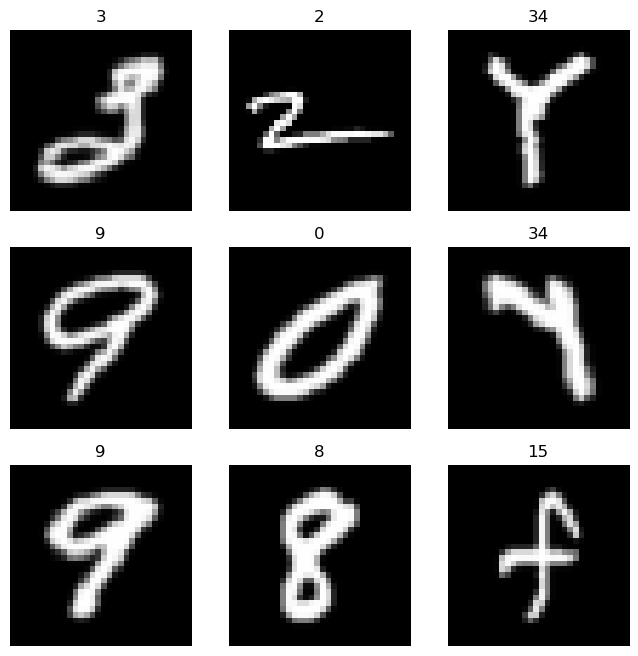

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(comb_test), size=(1,)).item()
    img, label = comb_test[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label) 
    plt.axis("off")
    plt.imshow(img.view(32,32), cmap="gray")
#plt.show()

In [8]:
class LeNet(nn.Module):
    def __init__(self, input_shape=(32, 32), num_classes=36):
        super(LeNet, self).__init__()
        # certain definitions
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(1,6,5, bias=False)
        self.conv2 = nn.Conv2d(6,16,5, bias=False)
        self.lin1 = nn.Linear(400,120, bias=False)
        # self.lin1 = nn.Linear(784,64)
        self.lin2 = nn.Linear(120,84, bias=False)
        self.lin3 = nn.Linear(84,num_classes, bias=False)
        
    def forward(self, x):
        shape_dict = {}
        '''        
        # neuron network
        #Layer3
        x = torch.flatten(x,1)
        shape_dict[1] = list(x.size())
        #Layer4
        x = F.relu(self.lin1(x))
        shape_dict[2] = list(x.size())
        #Layer5
        # x = F.relu(self.lin2(x))
        # shape_dict[3] = list(x.size())
        #Layer6
        out = self.lin2(x)
        shape_dict[3] = list(out.size())
        # out = self.lin3(x)
        # shape_dict[4] = list(out.size())
        '''
        # CNN
        #Layer1
        x = F.avg_pool2d(F.relu(self.conv1(x)),kernel_size=2,stride=2)
        shape_dict[1] = list(x.size())
        #Layer2
        x = F.avg_pool2d(F.relu(self.conv2(x)),kernel_size=2,stride=2)
        shape_dict[2] = list(x.size())
        #Layer3
        x = torch.flatten(x,1)
        shape_dict[3] = list(x.size())
        #Layer4
        x = F.relu(self.lin1(x))
        shape_dict[4] = list(x.size())
        #Layer5
        x = F.relu(self.lin2(x))
        shape_dict[5] = list(x.size())
        #Layer6
        out = self.lin3(x)
        shape_dict[6] = list(out.size())


        return out, shape_dict


def count_model_params():
    '''
    return the number of trainable parameters of LeNet.
    '''
    model = LeNet()
    model_params = 0.0
    for name, param in model.named_parameters():
        temp_result = 1
        for each in param.size():
            temp_result = temp_result*each
        model_params += temp_result
    return model_params/1000000


def train_model(model, train_loader, optimizer, criterion, epoch):
    """
    model (torch.nn.module): The model created to train
    train_loader (pytorch data loader): Training data loader
    optimizer (optimizer.*): A instance of some sort of optimizer, usually SGD
    criterion (nn.CrossEntropyLoss) : Loss function used to train the network
    epoch (int): Current epoch number
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    train_loss = 0.0
    
    for input, target in tqdm(train_loader, total=len(train_loader)):
        ###################################
        # fill in the standard training loop of forward pass,
        # backward pass, loss computation and optimizer step
        ###################################
        #might want to fix later TODO
        input = input.to(device)
        target = target.to(device)
        
        # 1) zero the parameter gradients
        optimizer.zero_grad()
        # 2) forward + backward + optimize
        output, _ = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Update the train_loss variable
        # .item() detaches the node from the computational graph
        # Uncomment the below line after you fill block 1 and 2
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print('[Training set] Epoch: {:d}, Average loss: {:.4f}'.format(epoch+1, train_loss))

    return train_loss


def test_model(model, test_loader, epoch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    correct = 0
    with torch.no_grad():
        for input, target in test_loader:
            input = input.to(device)
            target = target.to(device)
            output, _ = model(input)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_acc = correct / len(test_loader.dataset)
    print('[Test set] Epoch: {:d}, Accuracy: {:.2f}%\n'.format(
        epoch+1, 100. * test_acc))

    return test_acc


In [9]:
def save_checkpoint(state, is_best,
                    file_folder="./outputs/",
                    filename='checkpoint.pth.tar'):
    """save checkpoint"""
    if not os.path.exists(file_folder):
        os.makedirs(os.path.expanduser(file_folder), exist_ok=True)
    torch.save(state, os.path.join(file_folder, filename))
    if is_best:
        # skip the optimization state
        state.pop('optimizer', None)
        torch.save(state, os.path.join(file_folder, 'model_best.pth.tar'))







In [10]:
class MyArgs:
    resume = False #"./outputs/checkpoint.pth.tar"
    epochs = 1
    lr = 0.002
    batch_size = 128
args = MyArgs()

# main function for training and testing

# set up random seed
#torch.manual_seed(0)

###################################
# setup model, loss and optimizer #
###################################

model = LeNet()

training_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
# optim.Adam(model.parameters(), lr=args.lr)

# set up transforms to transform the PIL Image to tensors
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

################################
# setup dataset and dataloader #
################################

train_loader = torch.utils.data.DataLoader(comb_train , batch_size=args.batch_size,shuffle=True )
test_loader = torch.utils.data.DataLoader( comb_test , batch_size=args.batch_size,shuffle=True )

################################
# start the training           #
################################
# resume from a previous checkpoint
best_acc = 0.0
start_epoch = 0
if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{:s}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        # load model weight
        model.load_state_dict(checkpoint['state_dict'])
        # load optimizer states
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{:s}' (epoch {:d}, acc {:0.2f})".format(
            args.resume, checkpoint['epoch'], 100*best_acc))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

# training of the model
print("Training the model ...\n")
for epoch in range(start_epoch, args.epochs):
    # train model for 1 epoch
    train_model(model, train_loader, optimizer, training_criterion, epoch)
    # evaluate the model on test_set after this epoch
    acc = test_model(model, test_loader, epoch)
    # save the current checkpoint
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_acc' : max(best_acc, acc),
        'optimizer' : optimizer.state_dict(),
        }, (acc > best_acc))
    best_acc = max(best_acc, acc)
print("Finished Training")

Training the model ...



100%|██████████████████████████████████████████████████████████████████████████████| 1444/1444 [01:31<00:00, 15.83it/s]


[Training set] Epoch: 1, Average loss: 3.4654
[Test set] Epoch: 1, Accuracy: 43.55%

Finished Training


In [11]:
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (lin1): Linear(in_features=400, out_features=120, bias=False)
  (lin2): Linear(in_features=120, out_features=84, bias=False)
  (lin3): Linear(in_features=84, out_features=36, bias=False)
)

In [12]:
count_model_params() *1000000

63654.0

In [13]:
model.conv1.weight.shape

torch.Size([6, 1, 5, 5])

In [14]:
6*1*5*5 + 16*6*5*5 + 400*120 + 120*84 + 84*10

61470

In [15]:
model.conv2.weight.shape

torch.Size([16, 6, 5, 5])

In [16]:
model.lin1.weight.shape

torch.Size([120, 400])

In [17]:
model.lin2.weight.shape

torch.Size([84, 120])

In [18]:
import struct
write_file = open('test_weightfix.hex', 'w')
for i in range(len(model.conv1.weight.reshape(-1))):
    s_print = "@"+hex(i)[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', model.conv1.weight.reshape(-1)[i].item()))[0])[2:].zfill(8)
    write_file.write(s_print.strip()+'\n')
for i in range(len(model.conv2.weight.reshape(-1))):
    s_print = "@"+hex(i+len(model.conv1.weight.reshape(-1)))[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', model.conv2.weight.reshape(-1)[i].item()))[0])[2:].zfill(8)
    write_file.write(s_print.strip()+'\n')
for i in range(len(model.lin1.weight.reshape(-1))):
    s_print = "@"+hex(i+len(model.conv1.weight.reshape(-1))+len(model.conv2.weight.reshape(-1)))[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', model.lin1.weight.reshape(-1)[i].item()))[0])[2:].zfill(8)
    write_file.write(s_print.strip()+'\n')
for i in range(len(model.lin2.weight.reshape(-1))):
    s_print = "@"+hex(i+len(model.conv1.weight.reshape(-1))+len(model.conv2.weight.reshape(-1))+len(model.lin1.weight.reshape(-1)))[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', model.lin2.weight.reshape(-1)[i].item()))[0])[2:].zfill(8)
    write_file.write(s_print.strip()+'\n')
for i in range(len(model.lin3.weight.reshape(-1))):
    s_print = "@"+hex(i+len(model.conv1.weight.reshape(-1))+len(model.conv2.weight.reshape(-1))+len(model.lin1.weight.reshape(-1))+len(model.lin2.weight.reshape(-1)))[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', model.lin3.weight.reshape(-1)[i].item()))[0])[2:].zfill(8)
    write_file.write(s_print.strip()+'\n')
write_file.close()

In [19]:
model.lin1.weight

Parameter containing:
tensor([[ 0.0300,  0.0330, -0.0442,  ...,  0.0489, -0.0301,  0.0004],
        [ 0.0012, -0.0477, -0.0040,  ..., -0.0197,  0.0038,  0.0530],
        [ 0.0115,  0.0082, -0.0016,  ..., -0.0158,  0.0276,  0.0028],
        ...,
        [-0.0144,  0.0345,  0.0265,  ..., -0.0015, -0.0077,  0.0552],
        [ 0.0314, -0.0028,  0.0313,  ..., -0.0476, -0.0516,  0.0061],
        [-0.0022, -0.0445, -0.0331,  ..., -0.0474,  0.0122,  0.0132]],
       requires_grad=True)

In [20]:
len(model.lin1.weight.reshape(-1))

48000

In [21]:
import struct
write_file = open('weightfix.hex', 'w')
for i in range(len(model.lin1.weight.reshape(-1))):
    s_print = "@"+hex(i)[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', model.lin1.weight.reshape(-1)[i].item()))[0])[2:].zfill(8)
    write_file.write(s_print.strip()+'\n')
for i in range(len(model.lin2.weight.reshape(-1))):
    s_print = "@"+hex(i+len(model.lin1.weight.reshape(-1)))[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', model.lin2.weight.reshape(-1)[i].item()))[0])[2:].zfill(8)
    write_file.write(s_print.strip()+'\n')
write_file.close()

In [22]:
write_file = open('weightfix.hex', 'w')
for i in range(len(model.lin2.weight.reshape(-1))):
    s_print = "@"+hex(i+len(model.lin1.weight.reshape(-1)))[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', model.lin2.weight.reshape(-1)[i].item()))[0])[2:].zfill(8)
    write_file.write(s_print.strip()+'\n')
write_file.close()

In [23]:
for i in range(len(model.lin2.weight.reshape(-1))):
    print("@"+hex(i+len(model.lin1.weight.reshape(-1)))[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', model.lin2.weight.reshape(-1)[i].item()))[0])[2:].zfill(8), end="|")
print()

@bb80 bd94ca9a|@bb81 bb02d837|@bb82 3da0114a|@bb83 bd9a1a64|@bb84 3d1f0534|@bb85 bd406261|@bb86 bd866178|@bb87 bd446332|@bb88 bd8b9f8b|@bb89 bd4aae20|@bb8a 3d2bffa8|@bb8b bd1bbc15|@bb8c bd94310a|@bb8d 3d8f61b1|@bb8e 3ccd6654|@bb8f bd67a2f9|@bb90 bc5e00c2|@bb91 3ce64b2f|@bb92 3c59f178|@bb93 3d0c2bf0|@bb94 bda67f43|@bb95 bd9e3d81|@bb96 3da27986|@bb97 3db99ff7|@bb98 3db564f9|@bb99 bd8ebed2|@bb9a bb8b1afa|@bb9b bd24c621|@bb9c bd94aef6|@bb9d bd9ca081|@bb9e bce5a6b8|@bb9f 3d7f4e0f|@bba0 3d9af189|@bba1 bd9c3ed2|@bba2 3d8ea06d|@bba3 bd317a6c|@bba4 bcc44301|@bba5 bced1db7|@bba6 bd4ba146|@bba7 3d069ad3|@bba8 bcde18b4|@bba9 bd4e94c1|@bbaa 3d5f9e1c|@bbab 3d26e74c|@bbac 3dae3d7b|@bbad bc8a566b|@bbae 3d8fbd3e|@bbaf 3d3d3147|@bbb0 bd9409ef|@bbb1 bd0fd96d|@bbb2 3d245d58|@bbb3 3d7c7c0a|@bbb4 bcd323b4|@bbb5 bd9e20a1|@bbb6 bc556862|@bbb7 3d1ebfac|@bbb8 3d9954f4|@bbb9 bc8161d7|@bbba bdadc9ee|@bbbb 3c09301f|@bbbc bd94d2a6|@bbbd 3cf31775|@bbbe 3d897e2c|@bbbf 3d0c2b64|@bbc0 bdafe26f|@bbc1 bbd501da|@bbc2 3d38

@d852 3d9eae36|@d853 3e02bf5b|@d854 3d6e1c58|@d855 bcd27b28|@d856 3d1553ea|@d857 bcebc18e|@d858 3d065e9c|@d859 3bf4bd99|@d85a bd05694c|@d85b 3dc90559|@d85c 3c322d37|@d85d bd79bf5e|@d85e bd88ae31|@d85f 3bf94e64|@d860 3d811349|@d861 bd951076|@d862 bd4cb80f|@d863 bd9e011d|@d864 3ced30a9|@d865 bc9ba18f|@d866 bc62409d|@d867 3ba5944f|@d868 bd98b3ae|@d869 bbfb524d|@d86a bd97e009|@d86b 3db905a3|@d86c 3d7a5377|@d86d 3cdc0584|@d86e 3ccb24df|@d86f baccdc1d|@d870 bd71cd74|@d871 3ded3d82|@d872 bd572f4c|@d873 bd145533|@d874 bd52bfaf|@d875 3d2eeede|@d876 3cdfc673|@d877 3d906977|@d878 3c6dd370|@d879 3d80bab3|@d87a 3ce539d4|@d87b bc96f70e|@d87c bd881675|@d87d bdb2f16a|@d87e 3dbb0e11|@d87f 3de99251|@d880 3db6504d|@d881 bd537bca|@d882 bd1ec799|@d883 bda07104|@d884 3c5a1c78|@d885 3c529d86|@d886 bce84e57|@d887 bd168c42|@d888 3caeefa1|@d889 bd99be8a|@d88a bcbd56df|@d88b 3dee8121|@d88c bd1b085b|@d88d 3d8ce065|@d88e bd30c384|@d88f bc1662c3|@d890 bb615e20|@d891 bd211913|@d892 bbbe2b57|@d893 bd826978|@d894 bd21

In [24]:
count_model_params() * 1000000

63654.0

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
correct = 0
with torch.no_grad():
    input = torch.FloatTensor(comb_test[sample_idx][0]*256).reshape(1, 1, 32, 32)
    input = input.to(device)
    output, _ = model(input)
output

tensor([[ -608.9047,   284.9330,  -688.0191,    48.4678,   497.1176,     2.2051,
         -1087.6122,   -24.2850,   471.2502,   706.3730,   171.5133,  -218.7251,
          -808.0037,  -415.6238,    11.3517,   336.5255,    11.8498,   -93.1355,
           396.7831,  -386.4110,    93.4404,    38.5871,   -32.9111,  -347.9089,
          -177.7872,   472.2256,   197.9459,   220.3017,    21.1013,   660.4080,
         -1047.1636,    76.1283, -1041.0293,   531.3123,   678.3359,    75.8708]])

In [26]:
output.max(1, keepdim=True)[1]

tensor([[9]])

In [28]:
max(output.reshape(36).tolist())

706.3729858398438

In [30]:
output.reshape(36).tolist().index(max(output.reshape(36).tolist()))

9

In [31]:
comb_test[sample_idx][0].reshape(-1)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [32]:
import struct
for i in range(len(comb_test[sample_idx][0].reshape(-1))):
    print("@"+hex(i)[2:].zfill(4)+" "+hex(struct.unpack('<I', struct.pack('<f', comb_test[sample_idx][0].reshape(-1)[i].item()))[0])[2:].zfill(8), end="|")
print()

@0000 00000000|@0001 00000000|@0002 00000000|@0003 00000000|@0004 00000000|@0005 00000000|@0006 00000000|@0007 00000000|@0008 00000000|@0009 00000000|@000a 00000000|@000b 00000000|@000c 00000000|@000d 00000000|@000e 00000000|@000f 00000000|@0010 00000000|@0011 00000000|@0012 00000000|@0013 00000000|@0014 00000000|@0015 00000000|@0016 00000000|@0017 00000000|@0018 00000000|@0019 00000000|@001a 00000000|@001b 00000000|@001c 00000000|@001d 00000000|@001e 00000000|@001f 00000000|@0020 00000000|@0021 00000000|@0022 00000000|@0023 00000000|@0024 00000000|@0025 00000000|@0026 00000000|@0027 00000000|@0028 00000000|@0029 00000000|@002a 00000000|@002b 00000000|@002c 00000000|@002d 00000000|@002e 00000000|@002f 00000000|@0030 00000000|@0031 00000000|@0032 00000000|@0033 00000000|@0034 00000000|@0035 00000000|@0036 00000000|@0037 00000000|@0038 00000000|@0039 00000000|@003a 00000000|@003b 00000000|@003c 00000000|@003d 00000000|@003e 00000000|@003f 00000000|@0040 00000000|@0041 00000000|@0042 0000

@03f8 00000000|@03f9 00000000|@03fa 00000000|@03fb 00000000|@03fc 00000000|@03fd 00000000|@03fe 00000000|@03ff 00000000|


In [33]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
output = model((comb_test[sample_idx][0]*255).reshape(32,32).T.reshape(1, 1, 32,32))
print(activation['conv1'].shape)

torch.Size([1, 6, 28, 28])


In [34]:
write_file = open('con1.txt', 'w')
for i in activation['conv1'].reshape(6*28*28):
    write_file.write(str(i.item())+"\n")
write_file.close()

In [35]:
write_file = open('test_fixed_image_cnn.hex', 'w')
for i in range(len(comb_test[sample_idx][0].reshape(-1))):
    s_print = "@"+hex(i)[2:].zfill(4)+" "+hex(int(comb_test[sample_idx][0].reshape(-1)[i]*255))[2:].zfill(2)
    write_file.write(s_print.strip()+'\n')
write_file.close()

In [36]:
for i in range(len(comb_test[sample_idx][0].reshape(-1))):
    print(i, comb_test[sample_idx][0].reshape(-1)[i]*255)

0 tensor(0.)
1 tensor(0.)
2 tensor(0.)
3 tensor(0.)
4 tensor(0.)
5 tensor(0.)
6 tensor(0.)
7 tensor(0.)
8 tensor(0.)
9 tensor(0.)
10 tensor(0.)
11 tensor(0.)
12 tensor(0.)
13 tensor(0.)
14 tensor(0.)
15 tensor(0.)
16 tensor(0.)
17 tensor(0.)
18 tensor(0.)
19 tensor(0.)
20 tensor(0.)
21 tensor(0.)
22 tensor(0.)
23 tensor(0.)
24 tensor(0.)
25 tensor(0.)
26 tensor(0.)
27 tensor(0.)
28 tensor(0.)
29 tensor(0.)
30 tensor(0.)
31 tensor(0.)
32 tensor(0.)
33 tensor(0.)
34 tensor(0.)
35 tensor(0.)
36 tensor(0.)
37 tensor(0.)
38 tensor(0.)
39 tensor(0.)
40 tensor(0.)
41 tensor(0.)
42 tensor(0.)
43 tensor(0.)
44 tensor(0.)
45 tensor(0.)
46 tensor(0.)
47 tensor(0.)
48 tensor(0.)
49 tensor(0.)
50 tensor(0.)
51 tensor(0.)
52 tensor(0.)
53 tensor(0.)
54 tensor(0.)
55 tensor(0.)
56 tensor(0.)
57 tensor(0.)
58 tensor(0.)
59 tensor(0.)
60 tensor(0.)
61 tensor(0.)
62 tensor(0.)
63 tensor(0.)
64 tensor(0.)
65 tensor(0.)
66 tensor(0.)
67 tensor(0.)
68 tensor(0.)
69 tensor(0.)
70 tensor(0.)
71 tensor(0.)
72

678 tensor(0.)
679 tensor(0.)
680 tensor(0.)
681 tensor(0.)
682 tensor(0.)
683 tensor(0.)
684 tensor(0.)
685 tensor(0.)
686 tensor(0.)
687 tensor(9.)
688 tensor(217.)
689 tensor(127.)
690 tensor(4.)
691 tensor(0.)
692 tensor(0.)
693 tensor(0.)
694 tensor(0.)
695 tensor(0.)
696 tensor(0.)
697 tensor(0.)
698 tensor(0.)
699 tensor(0.)
700 tensor(0.)
701 tensor(0.)
702 tensor(0.)
703 tensor(0.)
704 tensor(0.)
705 tensor(0.)
706 tensor(0.)
707 tensor(0.)
708 tensor(0.)
709 tensor(0.)
710 tensor(0.)
711 tensor(0.)
712 tensor(0.)
713 tensor(0.)
714 tensor(0.)
715 tensor(0.)
716 tensor(0.)
717 tensor(0.)
718 tensor(0.)
719 tensor(46.)
720 tensor(241.)
721 tensor(127.)
722 tensor(4.)
723 tensor(0.)
724 tensor(0.)
725 tensor(0.)
726 tensor(0.)
727 tensor(0.)
728 tensor(0.)
729 tensor(0.)
730 tensor(0.)
731 tensor(0.)
732 tensor(0.)
733 tensor(0.)
734 tensor(0.)
735 tensor(0.)
736 tensor(0.)
737 tensor(0.)
738 tensor(0.)
739 tensor(0.)
740 tensor(0.)
741 tensor(0.)
742 tensor(0.)
743 tensor(0.)
7

In [37]:
(comb_test[sample_idx][0]*255).shape

torch.Size([1, 32, 32])

In [38]:
model.conv1.weight.reshape(6,5,5)

tensor([[[-1.0867e-01, -4.4141e-02,  6.3392e-02, -7.0711e-02, -9.5527e-02],
         [-1.5444e-01, -1.5021e-01, -1.3952e-01,  1.1463e-01, -9.5083e-02],
         [-6.9337e-02,  1.7666e-01,  1.8398e-01,  2.0924e-03, -1.2382e-01],
         [-1.9836e-01,  1.1352e-01,  8.2473e-02, -1.6474e-01,  1.5793e-01],
         [ 6.6336e-02,  1.7558e-02,  1.7351e-01, -1.3306e-01, -1.9306e-01]],

        [[-3.4942e-02,  1.7394e-01,  1.7189e-01,  4.4512e-04, -1.8302e-01],
         [-1.5591e-01,  6.9833e-02, -8.7036e-02, -4.1037e-03,  1.7431e-02],
         [-2.6456e-02, -1.1177e-01,  1.6249e-01,  1.5820e-01, -8.3423e-02],
         [ 2.0949e-01, -3.1144e-02, -1.4558e-02,  1.7783e-01, -1.6997e-01],
         [ 1.6431e-02,  1.1611e-01, -8.8803e-02,  1.9550e-01,  2.8096e-02]],

        [[-4.0875e-02,  1.6426e-01,  2.8234e-01,  2.7208e-02,  8.3184e-02],
         [ 6.2653e-02,  8.7075e-03,  2.9732e-01,  2.1307e-01, -9.7887e-02],
         [ 2.1200e-01,  2.0609e-01,  7.3845e-02, -6.1462e-02,  1.5992e-01],
        

In [39]:
model.conv1.weight.reshape(-1).shape

torch.Size([150])

In [40]:
import random
rand_img = []
for i in range(1024):
    #rand_img.append(random.randint(1, 255))
    rand_img.append(0)
rand_img[143] = 1
test_in  = torch.tensor(rand_img, dtype=torch.float)

In [41]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
output = model((comb_test[sample_idx][0]*255).reshape(1, 1, 32,32))
print(activation['conv1'].shape)

torch.Size([1, 6, 28, 28])


In [42]:
write_file = open('test_con1.txt', 'w')
for i in activation['conv1'].reshape(6*28*28):
    write_file.write(str(i.item())+"\n")
write_file.close()

In [43]:
F.avg_pool2d(F.relu(activation['conv1']),kernel_size=2,stride=2).shape

torch.Size([1, 6, 14, 14])

In [44]:
write_file = open('test_pool1.txt', 'w')
for i in F.avg_pool2d(F.relu(activation['conv1']),kernel_size=2,stride=2).view(-1):
    write_file.write(str(i.item())+"\n")
write_file.close()

In [45]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv2.register_forward_hook(get_activation('conv2'))
output = model((comb_test[sample_idx][0]*255).reshape(1, 1, 32,32))
print(activation['conv2'].shape)
write_file = open('test_con2.txt', 'w')
for i in activation['conv2'].reshape(16*10*10):
    write_file.write(str(i.item())+"\n")
write_file.close()
write_file = open('test_pool2.txt', 'w')
for i in F.avg_pool2d(F.relu(activation['conv2']),kernel_size=2,stride=2).view(-1):
    write_file.write(str(i.item())+"\n")
write_file.close()

torch.Size([1, 16, 10, 10])


In [46]:
model.conv2.weight

Parameter containing:
tensor([[[[ 3.4485e-02, -5.7480e-02,  7.3898e-03, -4.2985e-02,  1.8799e-02],
          [-7.3664e-02,  5.2844e-02,  1.9724e-02,  5.5943e-02,  4.5755e-02],
          [-1.3295e-03, -1.2021e-02,  1.3541e-02,  7.5492e-02, -4.7092e-02],
          [ 1.5639e-02,  5.4668e-02, -1.0358e-03, -2.2735e-02,  1.7458e-02],
          [ 4.9876e-02,  3.7230e-02,  3.9437e-02,  4.0853e-02,  5.3157e-02]],

         [[-5.8346e-02, -5.9878e-02, -1.4181e-03, -2.3925e-02, -5.7488e-02],
          [ 2.1708e-02,  3.6457e-02, -4.3180e-02, -4.8814e-02, -2.0082e-02],
          [ 4.8290e-02, -1.4097e-02,  6.8308e-02, -1.8536e-02, -1.8072e-02],
          [-7.1481e-02, -6.4290e-02,  5.6065e-02,  1.8171e-02,  1.5335e-02],
          [ 7.6540e-02,  3.2671e-03, -3.7156e-02,  4.2083e-02,  3.7896e-03]],

         [[ 9.2877e-02,  1.0590e-01,  8.1574e-02, -5.8164e-02,  6.2168e-02],
          [ 1.0837e-01,  3.0628e-02, -7.8389e-03,  4.8487e-02, -1.5554e-02],
          [-4.6541e-02,  9.1801e-02, -2.9984e-02, 

In [47]:
model.conv2.weight.shape

torch.Size([16, 6, 5, 5])

In [48]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.lin1.register_forward_hook(get_activation('lin1'))
output = model((comb_test[sample_idx][0]*255).reshape(1, 1, 32,32))
write_file = open('test_lin1.txt', 'w')
for i in activation['lin1'].reshape(1*120):
    write_file.write(str(i.item())+"\n")
write_file.close()

In [49]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.lin2.register_forward_hook(get_activation('lin2'))
output = model((comb_test[sample_idx][0]*255).reshape(1, 1, 32,32))
write_file = open('test_lin2.txt', 'w')
for i in activation['lin2'].reshape(1*84):
    write_file.write(str(i.item())+"\n")
write_file.close()

In [51]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.lin3.register_forward_hook(get_activation('lin3'))
output = model((comb_test[sample_idx][0]*255).reshape(1, 1, 32,32))
write_file = open('test_lin3.txt', 'w')
for i in activation['lin3'].reshape(1*36):
    write_file.write(str(i.item())+"\n")
write_file.close()